<a href="https://colab.research.google.com/github/JINU6497/JINUrepo/blob/master/Transfer_Learning_by_using_hymenoptera_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
'''1. 모듈 임포트하기'''

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [25]:
'''2. 딥러닝 모델 설계에 활용하는 장비 확인'''

if torch.cuda.is_available():
  DEVICE=torch.device("cuda")
else:
  DEVICE=torch.device("cpu")


In [26]:
BATCH_SIZE=32
EPOCHS=10

In [27]:
'''3. 데이터 다운(Train과 Test Set 분리)'''

data_transforms={
    'train':transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                ]), 
    'val':transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.Resize(256),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                ]),}

image_datasets={x:datasets.ImageFolder("/content/drive/MyDrive/hymenoptera_data/hymenoptera_data",data_transforms[x]) for x in ['train','val']}
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=BATCH_SIZE,num_workers=0,shuffle=True) for x in ['train','val']}

RandomResizedCrop(224)는 해당 이미지 중앙을 기준으로 224*224 크기로 이미지를 잘라내어 사이즈를 변경하는 것을 의미.

맨 아래 줄은 이미지 데이터를 불러오면서 기존에 정의한 data_transforms의 학습 데이터셋에 이용되는 전처리 과정, 검증 데이터셋에 이용되는 전처리 과정을 각각 적용하는 것을 의미. 이때 학습 데이터셋과 검증 데이터셋에 각각 적용하기 위하여 Dictionary 구조를 사용.


In [28]:
'''4. 데이터 확인'''

for (X_train, Y_train) in dataloaders['train']:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('Y_train:', Y_train.size(), 'type:', Y_train.type())  

X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.Lon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

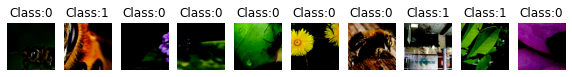

In [29]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class:'+str(Y_train[i].item()))

In [30]:
'''5. 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의'''
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image,label) in enumerate(train_loader):
    image=image.to(DEVICE)
    label=label.to(DEVICE)
    optimizer.zero_grad()
    output=model(image)
    loss=criterion(output,label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval==0:
      print("Train Epoch:{}[{}/{}({:.0f}%)]\tTraint Loss: {:.6f}".format(Epoch,batch_idx*len(image), len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()))
    

In [31]:
'''6. 학습 과정 속에서 Test 데이터에 대한 모델 성능 확인하는 함수 정의'''

def evaluate(model, test_loader):
  model.eval()
  test_loss=0
  correct=0

  with torch.no_grad():
    for image, label in test_loader:
      image=image.to(DEVICE)
      label=label.to(DEVICE)
      output=model(image)
      test_loss+=criterion(output,label).item()
      prediction=output.max(1,keepdim=True)[1]
      correct +=prediction.eq(label.view_as(prediction)).sum().item()

  test_loss/=len(test_loader.dataset)
  test_accuracy=100.*correct/len(test_loader.dataset)
  return test_loss, test_accuracy

In [32]:
'''7. PyTorch 내에서 제공하는 미리 학습되지 않은 ResNet18 모델을 볼러온 후 Output의 크기 설정'''

import torchvision.models as models
model=models.resnet18(pretrained=False).cuda()
num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs,2)
model=model.cuda()

torchvision내에 있는 models.resnet18을 불러온다. 이 모델에 대해 Fully Connected Layer를 구성하고 있는 부분에 접근. 이때 in_features는 resnet18 모델의 Fully Connected Layer의 input에 해당하는 노드 수를 num_ftrs로 저장. 이때 output은 벌과 개미 이미지 2개이기 때문에 2로 지정

In [33]:
'''8. Optimizer, Objective Function 설정'''

optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
criterion=nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
'''9. 미리 학습되지 않은 ResNet18 학습 실행 후 결과 확인'''

for Epoch in range(1, EPOCHS+1):
  train(model, dataloaders["train"],optimizer,log_interval=5)
  test_loss, test_accuracy=evaluate(model,dataloaders["val"])
  print("\n[EPOCH:{}],\tTest Loss:{:.4f}, \tTest Accuracy:{:.2f}%\n".format(Epoch,test_loss,test_accuracy))

Train Epoch:1[0/397(0%)]	Traint Loss: 0.746408
Train Epoch:1[160/397(38%)]	Traint Loss: 0.793705
Train Epoch:1[320/397(77%)]	Traint Loss: 0.694827

[EPOCH:1],	Test Loss:0.0286, 	Test Accuracy:38.54%

Train Epoch:2[0/397(0%)]	Traint Loss: 0.638515
Train Epoch:2[160/397(38%)]	Traint Loss: 0.661966
Train Epoch:2[320/397(77%)]	Traint Loss: 0.731717

[EPOCH:2],	Test Loss:0.0251, 	Test Accuracy:61.21%

Train Epoch:3[0/397(0%)]	Traint Loss: 0.621762
Train Epoch:3[160/397(38%)]	Traint Loss: 0.734293
Train Epoch:3[320/397(77%)]	Traint Loss: 0.672936

[EPOCH:3],	Test Loss:0.0220, 	Test Accuracy:61.71%

Train Epoch:4[0/397(0%)]	Traint Loss: 0.646585
Train Epoch:4[160/397(38%)]	Traint Loss: 0.595757
Train Epoch:4[320/397(77%)]	Traint Loss: 0.693303

[EPOCH:4],	Test Loss:0.0210, 	Test Accuracy:64.48%

Train Epoch:5[0/397(0%)]	Traint Loss: 0.723764
Train Epoch:5[160/397(38%)]	Traint Loss: 0.532669
Train Epoch:5[320/397(77%)]	Traint Loss: 0.592906

[EPOCH:5],	Test Loss:0.0207, 	Test Accuracy:63.98%

